# Análise Preditiva de Suicídios

## Descrição do dataset
Os dados foram coletados em forma de questionário através de redes sociais e emails. Alguns direcionados a grupos específicos de apoio (contra depressão). As questões abordadas foram baseadas nesta [pesquisa](https://www.kaggle.com/kingburrito666/the-demographic-rforeveralone-dataset). <br>

<b>Descrição das variáveis:</b><br>
* Q1: "Qual a sua idade?" <br>
* Q2: "Qual gênero você mais se identifica?" <br>
* Q3: "Qual sua orientação  sexual?" <br>
* Q4: "Qual o seu nível de renda anual?" <br>
* Q5: "Qual sua etnicidade?" <br>
* Q6: "Como você descreve sua massa corporal?" <br>
* Q7: "Você é virgem?" <br>
* Q8: "Você pagaria para ter uma relação sexual?" <br>
* Q9: "Quantos amigos você tem na vida real?" <br>
* Q10: "Você possui ansiedade/fobia social?" <br>
* Q11: "Você possui algum tipo de diagnóstico de transtorno mental?" <br>
* Q12: "Que tipo de ajuda você quer? <br>
* Q13: "Você já tentou se suicidar?" <br>
* Q14: "Qual seu status empregatício? Atualmente você é..." <br>
* Q15: "Qual seu cargo atual?" <br>
* Q16: "Qual seu nível de educação?" <br>
* Q17: "O que você fez para se sentir melhor consigo mesmo?" <br>
* Q18: "Com quem você mora?" <br>
* Q19: "Seus pais são divorciados?" <br>


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)

In [24]:
survey_data = pd.read_csv('survey_data.csv')

In [25]:
df = survey_data.iloc[:, 1:20]
df.columns = ['Q{}'.format(x+1) for x in range(0, 19)]
df.isnull().sum()

Q1     0  
Q2     0  
Q3     0  
Q4     6  
Q5     0  
Q6     0  
Q7     0  
Q8     0  
Q9     0  
Q10    0  
Q11    84 
Q12    0  
Q13    0  
Q14    0  
Q15    111
Q16    0  
Q17    0  
Q18    0  
Q19    0  
dtype: int64

## 1. Pré-processamento

In [26]:
def check_values_column(series):
    return pd.DataFrame(series.str.strip().unique()).sort_values(by=0)

In [27]:
def replace_values(df, column_name, values_search, value_replace):
    for value in values_search:
        contains_value = df[column_name].str.lower().str.contains(value)
        df[column_name] = np.where(contains_value == True, value_replace, df[column_name])

In [28]:
def create_age_range(df, feature_name, age_start, age_end):
    current = age_start
    step = 4
    
    while (current < age_end):
        age_endd = current + step
        
        df.loc[df.Q1.between(current, age_endd), feature_name] = \
        '{} à {} anos'.format(current, age_endd)

        current += (1 + step)


### 1.1 Variável Q1 - "Qual a sua idade?"
Limpeza e feature para a variável idade. <br>

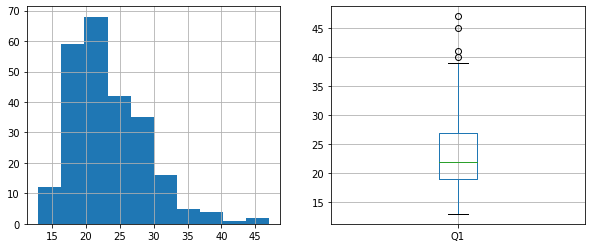

In [29]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
df.Q1.hist()

plt.subplot(1, 2, 2)
df.boxplot(column="Q1")



In [30]:
df.Q1.describe()

count    244.000000
mean     23.463115 
std      5.722193  
min      13.000000 
25%      19.000000 
50%      22.000000 
75%      27.000000 
max      47.000000 
Name: Q1, dtype: float64

#### 1.1.1 Feature por intervalo de idade

In [31]:
create_age_range(df, 'Q1_FAIXA_IDADE', 10, 49)

In [32]:
df.Q1_FAIXA_IDADE.value_counts()

20 à 24 anos    79
15 à 19 anos    70
25 à 29 anos    66
30 à 34 anos    16
35 à 39 anos    8 
40 à 44 anos    2 
45 à 49 anos    2 
10 à 14 anos    1 
Name: Q1_FAIXA_IDADE, dtype: int64

### 1.2 Variável Q2 - "Qual gênero você mais se identifica?"

In [33]:
df.Q2.value_counts()

Feminino         156
Masculino        85 
Não binário      1  
Agenero          1  
Gênero fluído    1  
Name: Q2, dtype: int64

In [34]:
replace_values(df, 'Q2', ['agenero', 'não binário', 'fluído'], 'Outros')

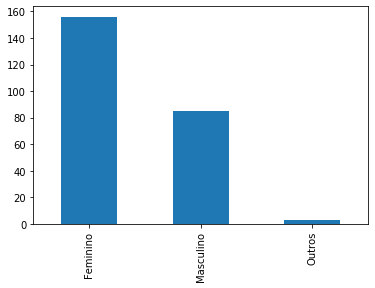

In [35]:
df.Q2.value_counts().plot.bar()
# plt.savefig('q2.png')

### 1.3 Variável Q3 - "Orientação sexual"
Limpeza e recategorização

In [36]:
df.Q3.value_counts(), df[df.Q3.isna()].shape

(Heterossexual               163
 Bissexual                   56 
 Homossexual                 15 
 Panssexual                  2  
 Pansexual                   2  
 Pansexual                   2  
 Assexual                    2  
 Não sei mt bem              1  
 Heterossexual bi-curioso    1  
 Name: Q3, dtype: int64, (0, 20))

In [37]:
replace_values(df, 'Q3', ['pansexual', 'panssexual'], 'Pansexual')
replace_values(df, 'Q3', ['bi-curioso', 'não sei'], 'Outros')

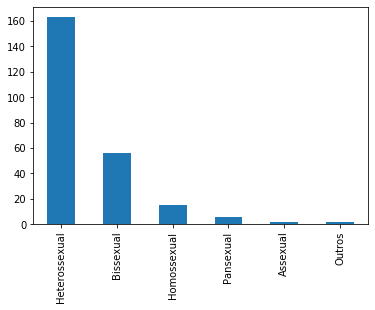

In [38]:
df.Q3.value_counts().plot.bar()
plt.savefig('q3.png')

### 1.4 Variável Q4 - "Qual o seu nível de renda anual"

In [45]:
df[df['Q4'].isna()]['Q14']

24     Estudante                               
112    Desempregado e procurando por um emprego
126    Estudante                               
151    Estudante                               
167    Estudante                               
184    Estudante                               
Name: Q14, dtype: object

In [40]:
df['Q4'].value_counts()

R$1,00 - R$9,999         101
R$10,000 - R$19,999      42 
R$20,000 - R$29,999      29 
R$50,000 - R$74,999      19 
R$200,000 ou mais        12 
R$30,000 - R$39,999      11 
R$40,000 - R$49,999      7  
R$75,000 - R$99,999      7  
R$125,000 - R$149,999    4  
R$100,000 - R$124,999    3  
R$175,000 - R$199,999    2  
R$150,000 - R$174,999    1  
Name: Q4, dtype: int64

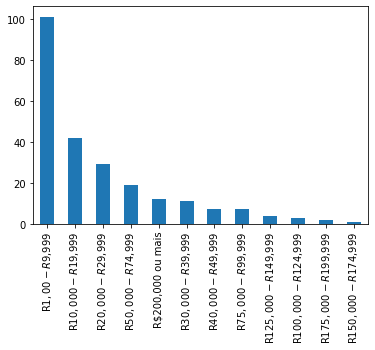

In [20]:
df['Q4'].value_counts().plot.bar()
plt.savefig('q4.png')

#### 1.4.1 Substituindo valores pela moda

Baseado na análise, os registros são referente a estudantes e/ou desempregados

In [21]:
mode = df['Q4'].value_counts().index[0]

In [22]:
df['Q4'].fillna(mode, inplace=True)

### 1.5 Variável Q5 - "Qual sua etnicidade?"

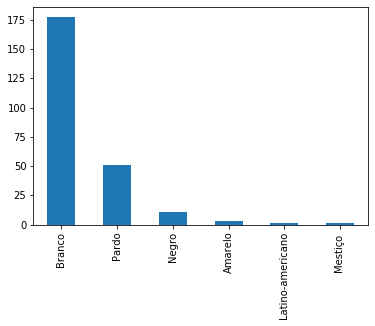

In [48]:
df['Q5'].value_counts().plot.bar()
plt.savefig('q5.png')

### 1.5 Variável Q6 - "Como você descreve sua massa corporal"

In [49]:
df.Q6.value_counts()

Peso normal                117
Acima do peso              71 
Abaixo do peso             30 
Obesidade I                16 
Obesidade II (severa)      5  
Muito abaixo do peso       3  
Obesidade III (mórbida)    2  
Name: Q6, dtype: int64

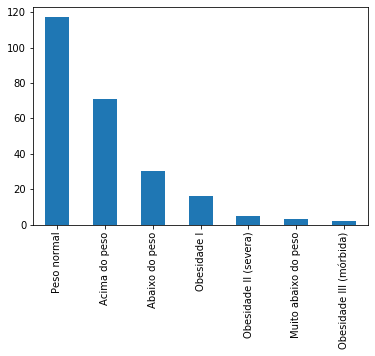

In [51]:
df.Q6.value_counts().plot.bar()
plt.savefig('q6.png')

### 1.11 Variável Q11
Esta variável envolve multipla seleção e digitação em campo livre.<br>
Os passos para tratamento serão:<br>
* Atribuir valor caso não tenha sido informado;
* Sobrescrever valores redundantes (digitados);
* Converter multipla seleção em colunas separadas;
* Converter as classes separadas para binário;
* Classificar valores digitados manualmente em categorias existentes e/ou criando novas (se necessário);

In [44]:
df[df['Q11'].isna()].shape

(84, 20)

In [45]:
df['Q11'].fillna('Sem resposta', inplace=True)

In [46]:
check_values_column(df['Q11'])

,0
21,Ansiedade de leve
12,"Apenas períodos de ansiedade + depressão , mas nao transtornos que me acompanharam durante a vida"
28,Nenhum
38,Nenhum (que eu saiba).
33,Nenhum diagnóstico
23,Não
39,Não possuo diagnóstico
30,Não tenho como responder pois evito procurar ajuda
45,"Não tenho nada diagnosticado, mas me sinto constantemente sobrecarregado e extremamente estressado. Pelo que leio, isso se chama Sindrome de Burn Out."
35,Não tenho transtorno mental


#### 1.5.1 Agrupando/sobrescrevendo valores redundantes

In [47]:
nenhum = 'Nenhum'

df.loc[df.Q11.str.lower().str.contains('nenhum'), 'Q11'] = nenhum
df.loc[df.Q11.str.lower().str.contains('não'), 'Q11'] = nenhum
df.loc[df.Q11.str.lower().str.contains('sem diagnóstico médico'), 'Q11'] = nenhum

outros = 'Outros'
df.loc[df.Q11.str.lower().str.contains('ansiedade de leve'), 'Q11'] = outros
df.loc[df.Q11.str.lower().str.contains('apenas períodos de ansiedade'), 'Q11'] = outros
df.loc[df.Q11.str.lower().str.contains('problemas psicológicos após lesão corporal'), 'Q11'] = outros
df.loc[df.Q11.str.lower().str.contains('tdah'), 'Q11'] = outros

df.Q11 = df.Q11.str.strip().str.replace('toc', 'TOC', regex=True)

In [48]:
check_values_column(df['Q11'])

,0
21,Nenhum
11,Outros
1,Sem resposta
0,"Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)"
29,"Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...);Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)"
19,"Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...);Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)"
15,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...)"
34,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...);Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...);Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)"
18,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...);Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)"
26,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...);Transtornos de Ansiedade (Fobia Específica, Transtorno de Ansiedade Generalizada, Transtorno de Pânico, etc...)"


#### 1.5.2 Transformando variáveis categóricas em binário
Criando colunas binárias separadas para cada tipo de transtorno.

In [49]:
df_Q11 = pd.get_dummies(df['Q11'].str.strip().str.split(';', expand=True))

df['Q11_T1'] = df_Q11[['0_Transtornos Alimentares  (Anorexia, Bulimia, Transtorno de Ruminação, etc...)']].max(axis=1)

df['Q11_T2'] = df_Q11[['0_Transtornos de Ansiedade (Fobia Específica, Transtorno de Ansiedade Generalizada, Transtorno de Pânico, etc...)',
                       '1_Transtornos de Ansiedade (Fobia Específica, Transtorno de Ansiedade Generalizada, Transtorno de Pânico, etc...)']].max(axis=1)

df['Q11_T3'] = df_Q11[['0_Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)',
                       '1_Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)',
                       '2_Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)']].max(axis=1)

df['Q11_T4'] = df_Q11[['0_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)',
                       '1_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)',
                       '2_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)',
                       '3_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)']].max(axis=1)

df['Q11_T5'] = df_Q11[['0_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '1_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '2_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '3_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '4_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)']].max(axis=1)

df['Q11_T6'] = df_Q11[['0_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '1_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '2_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '3_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '4_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '5_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)']].max(axis=1)

df['Q11_T7'] = df_Q11[['1_TOC', '2_TOC', '5_TOC']].max(axis=1)

In [50]:
df['Q11_T8'] = df_Q11[['0_Outros']].max(axis=1)
df['Q11_T9'] = df_Q11[['0_Sem resposta']].max(axis=1)

In [51]:
df = df.drop(columns='Q11')

In [52]:
df.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q12',
       'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q1_FAIXA_IDADE',
       'Q11_T1', 'Q11_T2', 'Q11_T3', 'Q11_T4', 'Q11_T5', 'Q11_T6', 'Q11_T7',
       'Q11_T8', 'Q11_T9'],
      dtype='object')

### 1.15 Variável Q15

In [53]:
df['Q15'].str.strip().value_counts()

Estudante                                                 20
Estagiário                                                4 
Professor                                                 3 
Estagiária                                                3 
analista de sistemas                                      2 
Estágio                                                   2 
Analista de sistema                                       2 
Vendedora                                                 2 
Desenvolvedor de Software                                 2 
professora                                                2 
Gerente                                                   2 
Recepcionista                                             2 
Bolsista                                                  2 
Auxiliar de cartório                                      2 
Desenvolvedor de Sistemas                                 2 
Dev                                                       2 
Promotora de vendas     

#### 1.14.1 Agrupando valores

In [26]:
desenvolvimento = ['desenvolvedor', 'dev', 'analista', 'software', 'inteligência artificial']
ciencia_de_dados = ['dados', 'estatístico']
estudante = ['estudante', 'caloura', 'bolsista', 'escola', 'terceiro ano']
professor = ['professor', 'ministro aula casualmente']
estagiario = ['estagiári', 'estágio']
vendas = ['vendedor', 'vendas', 'atendente', 'call center', 'marketing', 'operador de caixa']
recepcionista = ['recepcionista', 'recepçao']
autonomo = ['dono', 'autônoma', 'empreendedor', 'empresária']
lideranca = ['gerente', 'diretor', 'líder']

replace_values(df, 'Q15', desenvolvimento, 'Desenvolvimento de Software')
replace_values(df, 'Q15', estudante, 'Estudante')
replace_values(df, 'Q15', estagiario, 'Estágio')
replace_values(df, 'Q15', professor, 'Educação')
replace_values(df, 'Q15', vendas, 'Vendas / Telemarketing')
replace_values(df, 'Q15', recepcionista, 'Recepcionista')
replace_values(df, 'Q15', autonomo, 'Empresário(a) / Empreendedor(a) / Autônomo(a)')
replace_values(df, 'Q15', ciencia_de_dados, 'Ciência de Dados')
replace_values(df, 'Q15', lideranca, 'Diretoria / Gerência / Liderança')
replace_values(df, 'Q15', ['redator'], 'Redator(a)')
replace_values(df, 'Q15', ['psic'], 'Psicologia')
replace_values(df, 'Q15', ['pesquisador'], 'Pesquisador(a)')
replace_values(df, 'Q15', ['coordenad'], 'Coordenador(a)')
replace_values(df, 'Q15', ['adm'], 'Administrativo')
replace_values(df, 'Q15', ['arquitet'], 'Arquiteto(a)')

df['Q15'].fillna('Sem resposta', inplace=True)

In [27]:
df.describe()

,Q1,Q9,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_T7,Q11_T8,Q11_T9
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.00000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,23.463115,15.323770,0.102459,0.463115,0.069672,0.29918,0.102459,0.077869,0.012295,0.016393,0.344262
std,5.722193,40.952217,0.303874,0.499663,0.255117,0.45884,0.303874,0.268516,0.110426,0.127244,0.476104
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,4.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,7.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,27.000000,10.500000,0.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,47.000000,500.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
max(df.isnull().sum())

0

In [29]:
df['Q12']

0      Terapia                                                      
1      Não quero ajuda                                              
2      Não quero ajuda                                              
3      Amigos;Terapia                                               
4      Terapia                                                      
5      Amigos;Conselheiro;Terapia                                   
6      Amigos;Não sei                                               
7      Não quero ajuda                                              
8      Terapia                                                      
9      Amigos;Conselheiro;Terapia                                   
10     Amigos;Conselheiro                                           
11     Amigos;Terapia                                               
12     Amigos;Terapia                                               
13     Não quero ajuda                                              
14     Amigos                     